In [1]:
%load_ext autoreload
%autoreload 2
import re
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import glob
import csv
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import random as rand
from ipywidgets import *
import colorlover as cl
from scipy import stats
import importlib
import sys
sys.path.append(os.getcwd()+'\\..')
from utils import utils
from utils import plot_utils_fig2p5 as pu
from utils import zscores
import matplotlib.patches as patches
from matplotlib import gridspec
import cmocean
sys.path.append(r'C://users/efink/documents/github/calculate_choice_prob/')
import calculate_auc as ca
import matplotlib.patches as patch
from Aggregate_logs import aggregate_logs
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import itertools

In [2]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=14)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 1

# Load, concatenate, save data across sessions

In [3]:
data_directory = r'C:\Users\efink\Documents\Github\crossmodal\Figure8'

log_df, unit_key_df = utils.load_data(data_directory)
opto_df = pd.read_hdf('opto_log_df.h5', 'table')

log_df['stim_duration'] = (log_df['stim_offset']-log_df['stim_onset']).round(2)
unique_sessions = log_df[['mouse_name', 'date']].drop_duplicates().sort_values(['mouse_name', 'date'])

# Label trials appropriately so that they can be grouped together for analysis

### As a control condition there are days where laser light was blocked from inhibiting cortex but was still given within the behavioral box - these are sham days

In [4]:
sham_days = {'EF0131': ['07-01-18', '07-07-18', '07-09-18b', '07-12-18', '07-19-18', '07-23-18', '07-26-18'], 
             'EF0114': ['07-11-18', '07-12-18', '07-14-18'], 
             'EF0132': ['07-11-18', '07-17-18', '07-21-18', '07-25-18'],
             'EF0144': ['08-15-18','08-22-18', '08-25-18', '08-30-18'],
            'YT045':['07-14-18','07-27-18','08-06-18','08-30-18']}

### Also trials where the 150ms stimuli were given (long) and those where the 50 ms stimuli were given (50 ms) as well as those occuring during sham days

In [5]:
sham_df = pd.concat([pd.DataFrame({key:arr}).melt() for key, arr in sham_days.items()])
sham_df = sham_df.rename(columns = {'variable': 'mouse_name', 'value':'date'})
sham_df['session_type'] = 'sham'
log_df_sham = sham_df.merge(log_df, on = ['mouse_name', 'date'], how = 'left')
log_df_sham = log_df_sham.dropna(axis = 0, subset = ['trial_num'])

non_sham_rows = ~log_df['uni_id'].isin(log_df_sham['uni_id'])
non_sham_days = log_df.loc[non_sham_rows].groupby(['mouse_name', 'date'])
non_sham_df = non_sham_days['stim_duration'].max().reset_index()
non_sham_df = non_sham_df.rename(columns = {'stim_duration':'session_type'})
non_sham_df.loc[non_sham_df['session_type'] == 0.15, 'session_type'] = 'long'
non_sham_df.loc[non_sham_df['session_type'] == 0.05, 'session_type'] = 'short'
log_df_nonsham = log_df.merge(non_sham_df, on = ['mouse_name', 'date'], how = 'right')

log_df = pd.concat([log_df_sham, log_df_nonsham]).reset_index(drop = True)

In [6]:
opto_df_pulses = opto_df.drop_duplicates(['mouse_name', 'date'])[['mouse_name', 'date', 'opto_stim_onsets']]

### Label groups of trials based on opto-stim type

In [7]:
def find_pulse(trial_start, opto_onsets):
    if trial_start > opto_onsets[-1]:
        pulse = np.nan
    else:
        pulse = min(opto_onsets[opto_onsets>trial_start])
    return pulse

In [8]:
log_df = log_df.merge(opto_df_pulses, how = 'left', on = ['mouse_name', 'date'])

In [9]:
log_df['opto_stim_onsets'] = log_df.apply(lambda x: find_pulse(x['trial_onset'], x['opto_stim_onsets']), axis = 1)
log_df['opto_stim_onsets'] = np.abs(np.round(log_df['opto_stim_onsets'] - log_df['trial_onset'] - log_df['stim_onset'], 2))
log_df.loc[log_df['trial_type'].str.contains('NoCue'), 'opto_stim_onsets'] = 'No_laser'
log_df.loc[log_df['trial_type'].str.contains('catch'), 'stim_onset'] = log_df['opto_stim_onsets']
log_df.loc[log_df['trial_type'].str.contains('catch'), 'opto_stim_onsets'] = 1
log_df[['trial_type', 'opto_stim_onsets']].head()

,trial_type,opto_stim_onsets
0,Stim_Som_NoCue,No_laser
1,catch,1
2,catch,1
3,Stim_Som_NoCue,No_laser
4,Stim_Som_NoCue,No_laser


### Catch trials are those where laser stimulus was given but no visual/tactile stimulus was given

In [10]:
catch_idx = log_df['trial_type'].str.contains('catch')
log_df.loc[catch_idx, 'spike_times(stim_aligned)'] = log_df.loc[catch_idx,'spike_times'] - log_df.loc[catch_idx,'stim_onset']

### Create a data table containing only behavioral outcomes and drops info about neurons and list how many days are in each condition

In [11]:
all_beh = log_df.drop_duplicates(['mouse_name', 'date','trial_num'])
all_beh[['mouse_name', 'date', 'session_type']].drop_duplicates().groupby(['mouse_name', 'session_type']).size()

mouse_name  session_type
EF0114      long            8
            sham            3
            short           7
EF0131      long            7
            sham            6
            short           4
EF0132      long            7
            sham            3
            short           4
EF0144      long            4
            sham            4
            short           4
YT045       long            6
            sham            3
            short           3
dtype: int64

In [12]:
### remove YT045 from data - failed mouse
log_df = log_df[log_df['mouse_name'] != 'YT045'].reset_index(drop = True)

In [13]:
#### during some sessions not all laser stimulus conditions were given - need to remove these for consistency
def identify_partial_sessions(grp):
    opto_onsets = grp['opto_stim_onsets']
    unique_onsets = opto_onsets.unique()
    return all([x in unique_onsets for x in ['No_laser', 1, 0.0, 0.05]])

log_df = log_df.loc[log_df['opto_stim_onsets'].isin(['No_laser', 1, 0.0, 0.05])]
full_sessions = log_df.groupby(['mouse_name', 'date']).apply(identify_partial_sessions).reset_index()
full_sessions = full_sessions.loc[full_sessions.loc[:,0], ['mouse_name', 'date']]
log_df = full_sessions.merge(log_df, how = 'left').reset_index(drop = True)
unit_key_df = full_sessions.merge(unit_key_df, how = 'left')

# Analysis of nueral data

#### calculate FRs and PSTHs

In [14]:
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)
unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size)

log_df['spike_counts(stim_aligned)'] = log_df['spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)

C:\Users\efink\Anaconda3\lib\site-packages\pandas\core\groupby.py:933: RuntimeWarning: Mean of empty slice
  f = lambda x: func(x, *args, **kwargs)
C:\Users\efink\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\efink\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


HBox(children=(IntProgress(value=0, max=613), HTML(value='')))

In [15]:
# unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window)
# unit_key_df['uni_id', 'FR_mean', 'FR_std']

In [16]:
### rename trial types since b-control names non- opto-stim trials as no-cue but we have another column with that information
log_df.loc[log_df['trial_type'] == 'Stim_Som_NoCue','trial_type'] = 'Stim_Som'
log_df.loc[log_df['trial_type'] == 'Stim_Vis_NoCue','trial_type'] = 'Stim_Vis'

In [17]:
grps = log_df.groupby(['uni_id'], sort = False)

In [18]:
def plot_laser_patch(ax_rast, trial_type):
    catch_num = sum(trial_type['trial_type'].str.contains('catch'))
    ax_rast.add_patch(patches.Rectangle((0.75,0), .1, catch_num, color = [0.3,0.3,0.3,0.6]))
    offset = 0
    for block_type, c in zip(['Visual','Whisker'], ['C1', 'C0']):
        num_trials_within_block = sum(trial_type['block_type'] == block_type)
        ax_rast.add_patch(patches.Rectangle((0.75,catch_num+offset), .1, num_trials_within_block, color = c, alpha = 0.6))
        offset += num_trials_within_block
        for opto_onsets in [0.05, 0.0]:
            long_trials = np.where((trial_type['opto_stim_onsets'] == 0.05) & (trial_type['block_type'] == block_type))[0]
            early_long_trials = np.where((trial_type['opto_stim_onsets'] == 0.0) & (trial_type['block_type'] == block_type))[0]
            ax_rast.add_patch(patches.Rectangle((0,min(early_long_trials)), 0.75, max(early_long_trials)- min(early_long_trials), color = 'c', alpha = 0.3))
            ax_rast.add_patch(patches.Rectangle((0.05,min(long_trials)-.49), 0.7,max(long_trials)- min(long_trials), color = 'c', alpha = 0.3))
            
def plot_psths(ax_hist, x_range, spike_means, spike_sems, color):
    ax_hist.plot(x_range, spike_means, color = color)
    ax_hist.fill_between(x_range, spike_means - spike_sems, spike_means + spike_sems, color = color, alpha =0.3)
           
def plot_indv_rast2(unit_name, unit, rast_axes, hist_axes1, hist_axes2):
    unit = unit.sort_values(['trial_type', 'block_type', 'opto_stim_onsets'])
    unit['spike_times(stim_aligned)'] = unit['spike_times(stim_aligned)'].apply(lambda x: x[(x>-0.25)&(x<0.75)])
    unit = unit[unit['opto_stim_onsets'].isin(['No_laser', 0.0, 0.05])]
    unit_touchS = unit[unit['trial_type'].str.contains('Som')]
    unit_visualS = unit[unit['trial_type'].str.contains('Vis')]
    color_gen = (colors for colors in zip((['c','c','C0'], ['c', 'c','C0']),(['c','c','C1'], ['c', 'c', 'C1'])))
   
    for mod, ax_rast, haxes1, haxes2, in zip([unit_touchS, unit_visualS], rast_axes, hist_axes1, hist_axes2):
        all_spikes = mod['spike_times(stim_aligned)'].as_matrix()
        
        ### plot rasters
        for trial_num in range(all_spikes.shape[0]):
            ax_rast.vlines(all_spikes[trial_num], trial_num-0.5, trial_num+0.5)
        
        ### plot PSTHs
        hist_grps = mod.groupby(['block_type', 'opto_stim_onsets'])
        spike_means = hist_grps.apply(lambda x: np.nanmean(np.vstack(x['spike_counts(stim_aligned)'].values), axis = 0))
        spike_sem = hist_grps.apply(lambda x: stats.sem(np.vstack(x['spike_counts(stim_aligned)'].values), axis = 0, nan_policy = 'raise'))
        
        ylim = np.max(np.concatenate(spike_means.values))
        for block_type, ax_hist, color_array, in zip(['Whisker', 'Visual'],  [haxes1, haxes2],[*next(color_gen)]):
            for color, tt in zip(color_array, range(3)):
                plot_psths(ax_hist, np.arange(-0.25, 0.75, 0.025), spike_means[block_type][tt][30:70], spike_sem[block_type][tt][30:70], color = color)
        
        plot_laser_patch(ax_rast, mod)
        
        ### prettify PSTHs
        for ax in [ax_rast,  haxes1, haxes2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_bounds(-0.25, 0.75)
            ax.set_xticks([-0.2, 0.0, 0.2, 0.4, 0.6])
            ax.set_xlim(-0.25, 0.85)
        
        for ax in [haxes1, haxes2]:
            ax.set_xticklabels(['-0.2', '0.0', '0.2', '0.4', '0.6'])
            ax.set_xlabel('Time from stim onset')
            ax.set_ylim(0, ylim+5)
            
        ax_rast.set_ylim(-.5,len(all_spikes)-.5)
        ax_rast.set_xticklabels([])
    
    ### prettify subplots
    hist_axes1[0].set_ylabel('Firing rate (hz)\n(Touch block)')
    hist_axes2[0].set_ylabel('Firing rate (hz)\n(Visual block)')
    rast_axes[0].set_ylabel('Trials')
    rast_axes[0].set_title('Touch trials')
    rast_axes[1].set_title('Visual trials')
    mpl.text(1.05, 0.7, 'Touch block', transform=rast_axes[1].transAxes )
    mpl.text(1.05, 0.3, 'Visual block', transform=rast_axes[1].transAxes )
    rast_axes[1].set_title('Visual trials')
    mpl.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

    return spike_sem

In [19]:
names = unit_key_df['uni_id']
x = (name for name in names.reset_index().loc[:,'uni_id'].values)

<bound method Figure.tight_layout of <Figure size 720x504 with 6 Axes>>

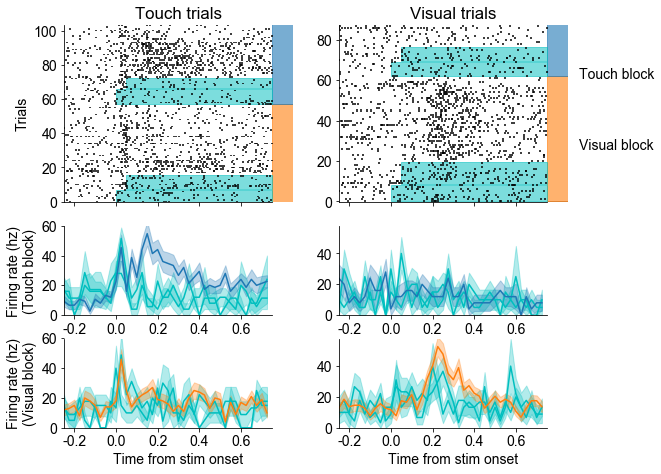

In [20]:
fig, axes = mpl.subplots(3,2, figsize = (10,7), gridspec_kw={'height_ratios': [2,1,1]})
unit_name = '11406-22-184t2'
unit = grps.get_group(unit_name)
sp = plot_indv_rast2(unit_name, unit, *axes)
fig.tight_layout
# fig.savefig('ex_raster2.png', format = 'png', dpi = 600)
# fig.savefig('ex_raster2.pdf',format='pdf', dpi=900, transparent = True)

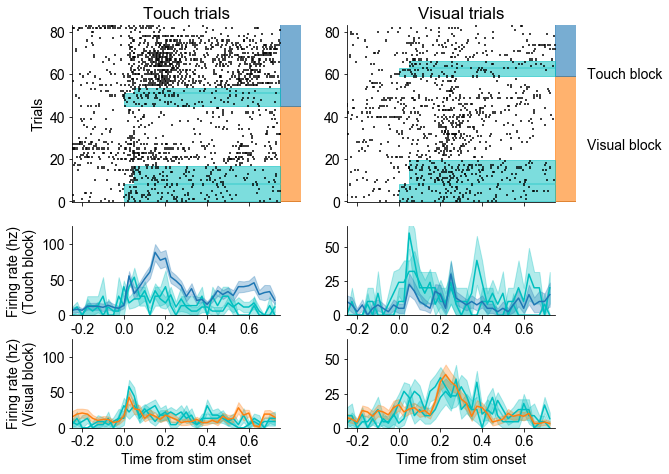

In [21]:
fig, axes = mpl.subplots(3,2, figsize = (10,7), gridspec_kw={'height_ratios': [2,1,1]})
unit_name = '11406-21-18b4t1'
unit = grps.get_group(unit_name)
sp = plot_indv_rast2(unit_name, unit, *axes)

11406-21-18b4t1


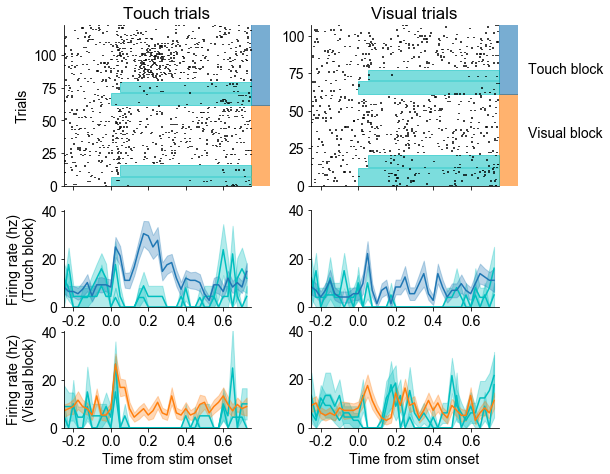

In [22]:
mpl.close('all')
fig, axes = mpl.subplots(3,2, figsize = (9,7), gridspec_kw={'height_ratios': [2,1.2,1.2]})

unit = grps.get_group('11407-16-181t5')
sp = plot_indv_rast2(unit_name, unit, *axes)
print(unit_name)
# fig.savefig('ex_raster1.pdf', format = 'pdf', dpi = 1200)

In [23]:
hists = log_df.groupby(['uni_id','trial_type','block_type', 'opto_stim_onsets']).apply(lambda x: np.mean(x['spike_counts(stim_aligned)'].values, axis = 0))
hists = hists.to_frame().reset_index()
hists['trial_type'] = hists[['block_type' ,'trial_type', 'opto_stim_onsets']].apply(lambda x: '_'.join([x['block_type'],x['trial_type'], str(x['opto_stim_onsets'])]), axis = 1)
hists = hists.drop(['block_type', 'opto_stim_onsets'] ,axis = 1)
trial_type_counts = hists['trial_type'].value_counts()
valid_trial_types = list(trial_type_counts[trial_type_counts>60].keys())
hists = hists[hists['trial_type'].isin(valid_trial_types)]
hists = hists.pivot('uni_id', columns = 'trial_type', values = 0).reset_index()

In [24]:
unit_key_df = unit_key_df[['uni_id','FR_mean', 'FR_std']]
unit_key_df = unit_key_df.merge(hists, on='uni_id', how = 'left')
unit_key_df = unit_key_df.merge(log_df[['uni_id', 'session_type']].drop_duplicates(), on='uni_id', how = 'left')

unit_zScores_df = unit_key_df.copy()
unit_zScores_df.iloc[:, 3:-1] = unit_zScores_df.iloc[:, 3:-1].apply(lambda x: (x-unit_zScores_df['FR_mean'])/unit_zScores_df['FR_std'])
unit_zScores_df['first_0.5s'] = unit_zScores_df['Whisker_catch_1'].apply(lambda x: np.mean(x[40:60]))
unit_zScores_df = unit_zScores_df.sort_values('first_0.5s')

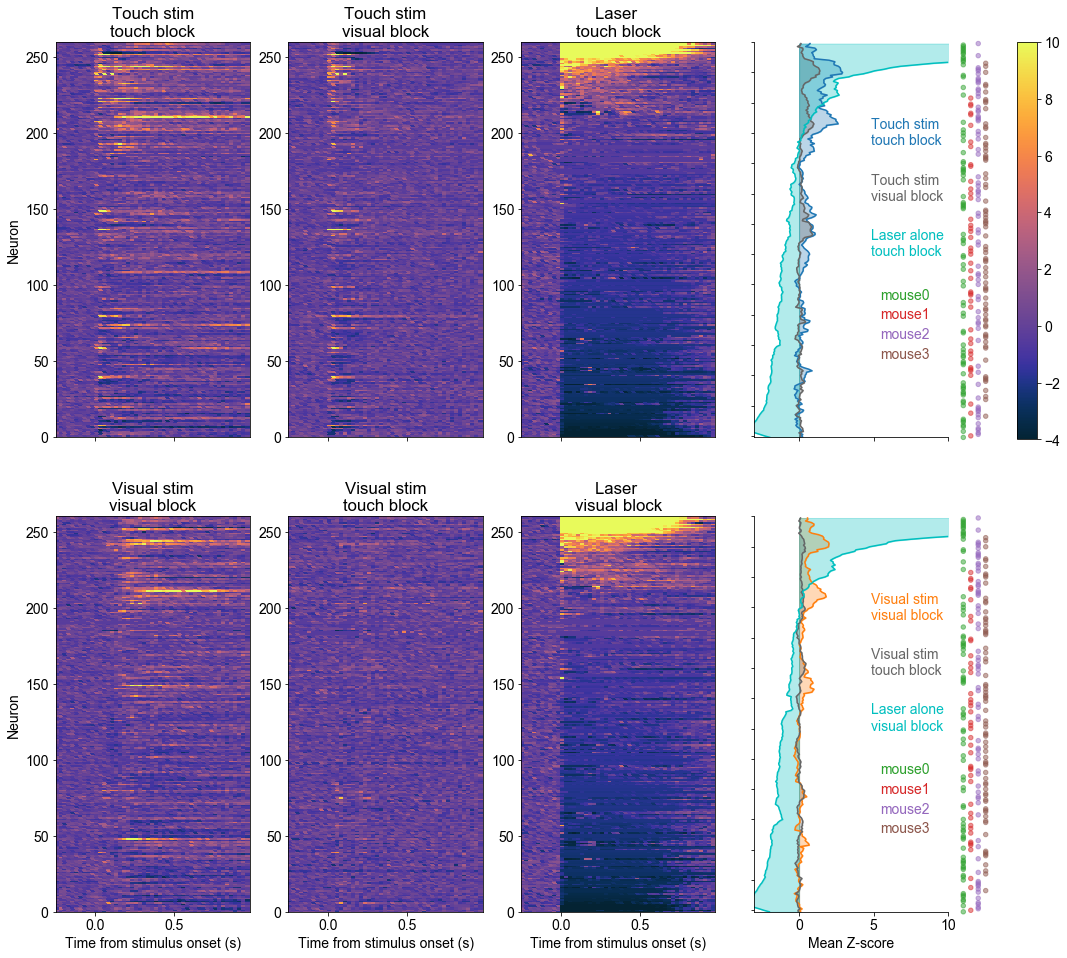

In [26]:
fig, ([ax1,ax2,ax3,ax9], [ax5,ax6,ax7,ax10]) = mpl.subplots(2,4, figsize = (16,16))

window = [-0.25, 1]
window_conv = ((np.array(window)+1)/0.025).astype(int)

group = unit_zScores_df[unit_zScores_df['session_type'] == 'long'].dropna()
names, group = group.iloc[:, 0], group.iloc[:,3:-2].applymap(lambda x: x[window_conv[0]:window_conv[1]])
names = names.to_frame().reset_index(drop = True)
mouse_names = names.merge(log_df[['uni_id', 'mouse_name']].drop_duplicates(), how = 'inner')
mouse_names['color'] = 'w'
mouse_names['x_offset'] = 0

for n, c,offset in zip(mouse_names['mouse_name'].unique(), ['C2', 'C3', 'C4', 'C5'], np.arange(0,2,0.5)):
    mouse_names.loc[mouse_names['mouse_name'] == n, 'color'] = c
    mouse_names.loc[mouse_names['mouse_name'] == n, 'x_offset'] = offset

trial_types = ['Whisker_Stim_Som_No_laser','Visual_Stim_Som_No_laser', 'Whisker_catch_1',
      'Visual_Stim_Vis_No_laser', 'Whisker_Stim_Vis_No_laser','Visual_catch_1']
titles = ['Touch stim\ntouch block', 'Touch stim\nvisual block', 'Laser \ntouch block',
         'Visual stim\nvisual block', 'Visual stim\ntouch block', 'Laser \nvisual block']

xx, yy = np.meshgrid(np.arange(window[0], window[1], 0.025), np.arange(0,group.shape[0]))
for tt,ax, title in zip(trial_types, [ax1,ax2,ax3,ax5,ax6,ax7], titles):
    pc = ax.pcolormesh(xx, yy, np.vstack(group[tt].apply(lambda x: x).values), vmin =-4, vmax = 10,cmap = cmocean.cm.thermal)
    pc.set_edgecolor('face')
    ax.set_title(title)
    ax.set_xlabel('Time from stimulus onset (s)')
#     ax.set_xticklabels(['-0.25', '0', '0.25', '0.5', '0.75'])

for col, tt in zip(['C0', [0.4,0.4,0.4], 'c'], ['Whisker_Stim_Som_No_laser','Visual_Stim_Som_No_laser', 'Whisker_Stim_Som_0.05']):
    marginal_z = np.mean(np.vstack(group[tt].apply(lambda x: x[9:29]).values), axis = 1) 
#     marginal_z = (np.convolve(marginal_z, [1/4]*4, mode = 'same') - np.mean(marginal_z))/(np.std(marginal_z) )
    marginal_z = (np.convolve(marginal_z, [1/10]*10, mode = 'same'))
    ax9.plot(marginal_z,np.arange(0,group[tt].shape[0]), color = col)
    ax9.fill_betweenx(np.arange(0,group[tt].shape[0]),marginal_z, color = col, alpha = 0.3)

for col, tt in zip(['C1', [0.4,0.4,0.4], 'c'], ['Visual_Stim_Vis_No_laser','Whisker_Stim_Vis_No_laser', 'Visual_Stim_Som_0.05']):
    marginal_z = np.mean(np.vstack(group[tt].apply(lambda x: x[9:29]).values), axis = 1) 
#     marginal_z = (np.convolve(marginal_z, [1/3]*3, mode = 'same') - np.mean(marginal_z))/(np.std(marginal_z))
    marginal_z = (np.convolve(marginal_z, [1/10]*10, mode = 'same'))

    ax10.plot(marginal_z,np.arange(0,group[tt].shape[0]), color = col)
    ax10.fill_betweenx(np.arange(0,group[tt].shape[0]),marginal_z, color = col, alpha = 0.3)

ax9.scatter(mouse_names['x_offset']+11, mouse_names.index, c = mouse_names['color'], s = 20, alpha = 0.5, clip_on = False)
ax10.scatter(mouse_names['x_offset']+11, mouse_names.index, c = mouse_names['color'], s = 20, alpha = 0.5, clip_on = False)

group_psth = group.iloc[:,3:-2].apply(lambda x: [np.mean(np.vstack(x.values), axis = 0)],axis = 0);
group_psth_vert = group.iloc[:,3:-2].apply(lambda x: [np.mean(np.vstack(x.values), axis = 1)],axis = 0);

for ax in [ax9,ax10]:
    ax.set_ylim(0,marginal_z.shape[0])
    ax.set_xlim(-3, 10)
    ax.set_yticks(np.arange(marginal_z.shape[0], 0, -20))
    ax.set_yticklabels(ax3.get_yticklabels())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Mean Z-score')
    for mn, c, y_offset in zip(['mouse'+str(i) for i in range(4)], ['C2', 'C3', 'C4', 'C5'], range(1,5)):
        mpl.text(.65, 0.4-y_offset*0.05, mn, transform=ax.transAxes, color = c)

for ax in [ax1,ax2,ax3, ax9]:
    ax.set_xticklabels([])
    ax.set_xlabel('')

for ax in [ax1, ax5]:
    ax.set_ylabel('Neuron')
mpl.text(.6, 0.74, 'Touch stim\ntouch block', transform=ax9.transAxes, color = 'C0')
mpl.text(.6, 0.6, 'Touch stim\nvisual block', transform=ax9.transAxes, color = [0.4, 0.4, 0.4])
mpl.text(.6, 0.46, 'Laser alone\ntouch block', transform=ax9.transAxes, color = 'c')

mpl.text(.6, 0.74, 'Visual stim\nvisual block', transform=ax10.transAxes, color = 'C1')
mpl.text(.6, 0.6, 'Visual stim\ntouch block', transform=ax10.transAxes, color = [0.4, 0.4, 0.4])
mpl.text(.6, 0.46, 'Laser alone\nvisual block', transform=ax10.transAxes, color = 'c')

cax = mpl.axes([0.96, 0.535, 0.017, 0.345])
# cax.axis('off')
cbar = mpl.colorbar(pc, cax = cax)
# fig.savefig('inhibition_long_heatmap.png', format = 'png', dpi = 750)
fig.savefig('inhibition_long_heatmap.pdf',format='pdf', dpi=900, transparent = True)

### Plot boxplots of FR for each bin for each condition

In [27]:
trial_types = ['Visual_Stim_Som_0.0',
               'Visual_Stim_Som_0.05', 'Visual_Stim_Som_No_laser',
               'Visual_Stim_Vis_0.0', 'Visual_Stim_Vis_0.05',
               'Visual_Stim_Vis_No_laser', 'Visual_catch_1', 'Whisker_Stim_Som_0.0',
               'Whisker_Stim_Som_0.05', 'Whisker_Stim_Som_No_laser',
               'Whisker_Stim_Vis_0.0', 'Whisker_Stim_Vis_0.05',
               'Whisker_Stim_Vis_No_laser', 'Whisker_catch_1']

In [28]:
### restrict dataframse to long sessions and
unit_key_df_long = unit_key_df.loc[unit_key_df['session_type'] == 'long'].copy()
unit_zScores_df = unit_zScores_df.drop(['FR_mean', 'FR_std'], axis = 1)
unit_key_df_long = unit_key_df_long.merge(unit_zScores_df, on = 'uni_id', how = 'left', suffixes = ('', '(zscore)'))
log_df_long = log_df.merge(unit_key_df_long['uni_id'].to_frame(), on = 'uni_id')

### remove inhibition trials
log_df_long = log_df_long[log_df_long['opto_stim_onsets'] == 'No_laser']

In [29]:
# auc = ca.calculate_small_batch(log_df_long, unit_key_df_long, unit_key_df_long['uni_id'], trial_type = 'Stim_Som', comparison = 'stim_prob_touch')
# auc.to_hdf('stim_prob_inhibition.h5', 'fixed')

In [30]:
auc = pd.read_hdf('stim_prob_inhibition.h5')

In [31]:
def find_sig_bins(up_arrays, down_arrays, num_bins):
    sig_raw = pd.DataFrame((up_arrays<0.5)*-1 + (down_arrays>0.5)*1)
    sig_conv = sig_raw.apply(lambda x: np.convolve(x, [1]*num_bins, 'same')*1,  axis = 1)
    sig_3 = (sig_conv >= num_bins)*1 + (sig_conv <= -num_bins)*-1
    
    return sig_3.values

In [32]:
### identify bins where unit has significant SP for two bins in a row
sig_bins = find_sig_bins(auc.loc[:,auc.columns.str.contains('up')].values, auc.loc[:,auc.columns.str.contains('low')].values, 2)

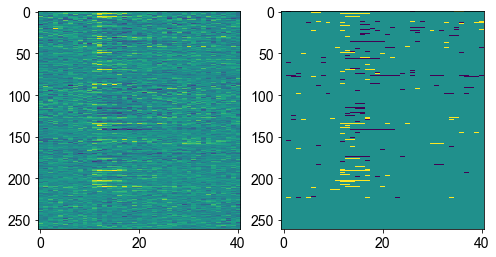

In [33]:
fig, axes = mpl.subplots(1,2, figsize = (8,4))
axes[0].imshow(auc.loc[:,auc.columns.str.contains('auc')], aspect = 'auto', vmin = 0.2, vmax = 0.8)
axes[1].imshow(sig_bins.astype(float), aspect = 'auto')

In [34]:
### identify units that are stim prob positive during tactile stimulus
unit_key_df_long['sig_stim_prob'] = (sig_bins[:, 9:19] == 1).any(axis = 1)

In [35]:
Whisker_Stim_Som_No_laser = np.vstack(unit_key_df_long['Whisker_Stim_Som_No_laser'].values)
Whisker_Stim_Vis_No_laser = np.vstack(unit_key_df_long['Whisker_Stim_Vis_No_laser'].values)

Whisker_Stim_Som_0p05 = np.vstack(unit_key_df_long['Whisker_Stim_Som_0.05'].values)
Whisker_Stim_Vis_0p05 = np.vstack(unit_key_df_long['Whisker_Stim_Vis_0.05'].values)

Whisker_Stim_Som_0p0 = np.vstack(unit_key_df_long['Whisker_Stim_Som_0.0'].values)
Whisker_Stim_Vis_0p0 = np.vstack(unit_key_df_long['Whisker_Stim_Vis_0.0'].values)

In [36]:
### baseline FR to normalize post stim firing rate
baseline = pd.DataFrame([tt[:, 17:37].mean(axis = 1) for tt in [Whisker_Stim_Som_No_laser, Whisker_Stim_Vis_No_laser, Whisker_Stim_Som_0p05, Whisker_Stim_Vis_0p05]]).T.mean(axis = 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001660FDE7BA8>,
      dtype=object)

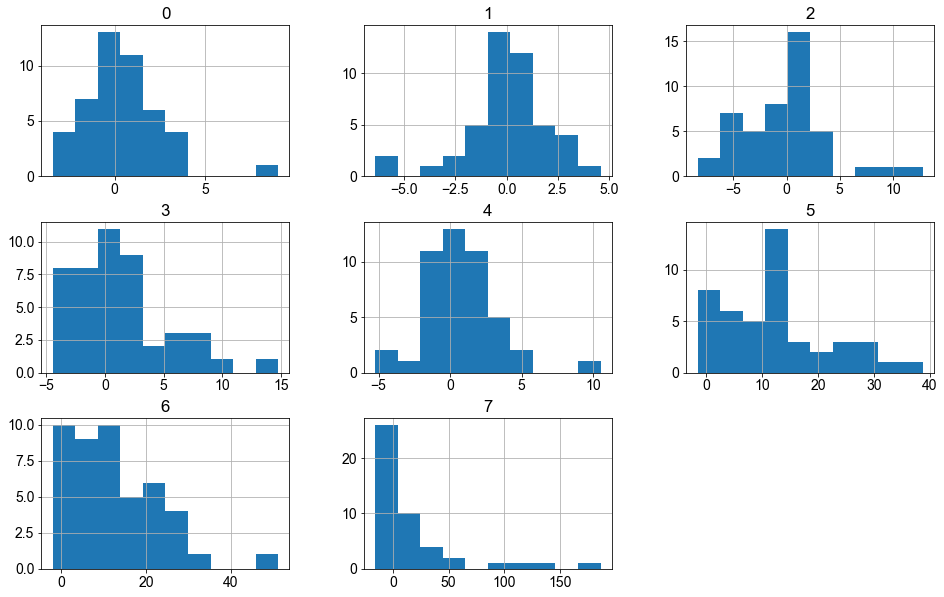

In [37]:
### check distribution of delta FRs for every 50 ms bin ranging from -0.05 to 0.15s from stimulus onset
## this will tell us what statistical test is appropriate when comparing laser stim conditions
all_data = []
for ax, bin_num in zip(axes, range(38,38+len(axes)*2,2)):
    sig_SP_inds = np.where(unit_key_df_long['sig_stim_prob'].values)[0]
    baseline_wind = baseline[sig_SP_inds].values
    data = [
        Whisker_Stim_Vis_No_laser[sig_SP_inds,bin_num:bin_num+2].mean(axis=1)- baseline_wind,
        Whisker_Stim_Som_No_laser[sig_SP_inds,bin_num:bin_num+2].mean(axis=1)- baseline_wind, 
        Whisker_Stim_Som_0p05[sig_SP_inds,bin_num:bin_num+2].mean(axis=1)- baseline_wind,
        Whisker_Stim_Som_0p0[sig_SP_inds,bin_num:bin_num+2].mean(axis=1)- baseline_wind
           ]
    all_data.append(pd.DataFrame(data))

pd.concat(all_data, axis = 0).reset_index(drop = True).T.hist(figsize = (16,10))

### Since distributions show high skew for some conditions it will be best to use non-parametric tests

In [38]:
def prettify_ax(ax, x_label, y_label, y_lim = None, x_lim = None):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    if y_lim:
        ax.set_ylim(y_lim)
        
    if x_lim:
        ax.set_xlim(x_lim)
        
    return ax

### Plot boxplots and perform Mann Whitney U test between tactile no laser and (tactile,0.05 laser offset) & (tactile,No offset laser conditions)

In [39]:
ax.get_xlim()

(-0.5, 40.5)

In [40]:
def sign_test(samp1, samp2):
    diff = samp1-samp2
    n = sum(diff != 0)
    n_pos = sum(diff > 0)
    n_neg = sum(diff < 0)
    succ = min(n_pos, n_neg)
    p = scipy.stats.binom_test(succ, n = n)
    return p

In [164]:

def permutation_test(x1, x2, num_perm):
    obs_diff = x2-x1
    obs_median = np.median(obs_diff)

    diff_len = len(obs_diff)
    diff_perm = np.tile(obs_diff, num_perm).reshape([num_perm,-1])

    signs = np.ones([num_perm, diff_len])
    signs[np.random.rand(num_perm, diff_len) > 0.5] = -1
    diff_perm = diff_perm * signs

    perm_medians = np.median(diff_perm, axis = 1)
    p_one_tailed = sum(perm_medians <= obs_median)/len(perm_medians), sum(perm_medians >= obs_median)/num_perm
    p_two_tailed = sum((abs(perm_medians) >= abs(obs_median)))/len(perm_medians)

    return p_two_tailed
    # hist = np.histogram(perm_medians, bins = np.arange(-15, 15, 0.1))
    # mpl.bar(hist[1][0:-1], hist[0],1)
    # mpl.axvline(0, linestyle = '--', color = 'k')
    # mpl.axvline(np.median(obs_diff), linestyle = '--', color = 'r')



stat_-0.05s  p_-0.05s  stat_0.00s  p_0.00s  \
Whisk_som      Whisk_som_0p0         0.383     0.383      0.0519   0.0519   
               Whisk_som_0p05        0.500     0.500      0.5000   0.5000   
Whisk_som_0p05 Whisk_som_0p0         0.500     0.500      0.1456   0.1456   

                               stat_0.05s  p_0.05s  stat_0.10s  p_0.10s  
Whisk_som      Whisk_som_0p0       0.0129   0.0129      0.0178   0.0178  
               Whisk_som_0p05      0.0519   0.0519      0.0080   0.0080  
Whisk_som_0p05 Whisk_som_0p0       0.1481   0.1481      0.4253   0.4253

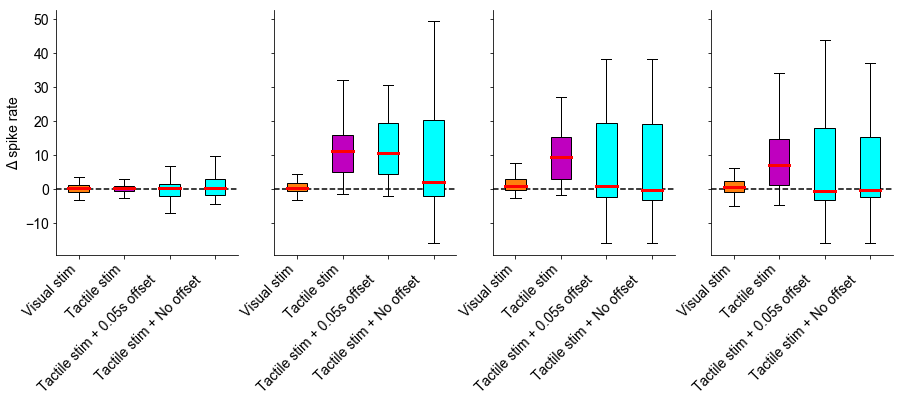

In [167]:
fig, axes = mpl.subplots(1,4, figsize = (15,4.5), sharey = True)

p_dicts = []
for ax, bin_num in zip(axes, range(38,38+len(axes)*2,2)):
    sig_SP_inds = np.where(unit_key_df_long['sig_stim_prob'].values)[0]
    baseline_wind = baseline[sig_SP_inds].values
    data = {
        'Whisk_vis' : Whisker_Stim_Vis_No_laser[sig_SP_inds,bin_num:bin_num+2].mean(axis=1)- baseline_wind,
        'Whisk_som' : Whisker_Stim_Som_No_laser[sig_SP_inds,bin_num:bin_num+2].mean(axis=1)- baseline_wind, 
        'Whisk_som_0p05' : Whisker_Stim_Som_0p05[sig_SP_inds,bin_num:bin_num+2].mean(axis=1)- baseline_wind,
        'Whisk_som_0p0' : Whisker_Stim_Som_0p0[sig_SP_inds,bin_num:bin_num+2].mean(axis=1)- baseline_wind
    }
    combs = itertools.combinations(['Whisk_som', 'Whisk_som_0p05', 'Whisk_som_0p0'],2)
    test_results = {comb_keys:sign_test(data[comb_keys[0]], data[comb_keys[1]],)/2 for comb_keys in combs}
    time_bin = (bin_num*0.025)-1
    p_dicts.append(pd.DataFrame(test_results, index = [f'stat_{time_bin:.2f}s', f'p_{time_bin:.2f}s']))
    bplot = ax.boxplot(data.values(), sym = '',patch_artist=True)
    
    for patch, medians, color in zip(bplot['boxes'], bplot['medians'], ['C1', 'm', [0,1,1], [0,1,1]]):
        patch.set_facecolor(color)
        mpl.setp(medians, color = 'r', linewidth = 3)
    
    y_label = ''
    if ax == axes[0]: 
        y_label = 'Δ spike rate'
    prettify_ax(ax, x_label = '', y_label = y_label)
    ax.axhline(0, linestyle = '--', color = 'k')
    ax.set_xticklabels(['Visual stim', 'Tactile stim', 'Tactile stim + 0.05s offset    ', 'Tactile stim + No offset    '], rotation = 45, ha = 'right')

display(pd.concat(p_dicts).round(4).T)